In [2]:
import utils_general
import utils_uncoup
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

# Experiment 1: Uncoupled 3 box model

### $C(r)\frac{\partial T(t)}{\partial{t}} = F(t) + \lambda(r) T(t)$,
where $C(r)$ is the heat capacity ($C = \rho_{\text{w}} \, c_{\text{w}} \, h(r)$, $\rho_{\text{w}} = 10^3$, $c_{\text{w}} = 4 \times 10^3$), $T(t)$ is the temperature, $F(t)$ is the effective radiative forcing, and $\lambda(r)$ is the local feedback parameter; $r$ denotes the region.

This relationship represents warming due to effective radiative forcing (ERF). This problem in 1D assumes that we are averaging over a few locations (e.g. land, Southern Ocean, and Arctic). The parameters of interest are given by:

| Parameter                                        | Symbol       | Fast  | Intermediate | Slow  |
|--------------------------------------------------|--------------|-------|--------------|-------|
| Effective water depth (m)                        | $h(r)$       | 10    | 150          | 1500  |
| Local Feedback (W m<sup>-2</sup> K<sup>-1</sup>) | $\lambda(r)$ | -0.86 | -2.0         | -0.67 |

We consider the following forcing profiles of interest:

| Forcing Type | Functional Form           | Value(s)                              |
|--------------|---------------------------|---------------------------------------|
| Constant     | $F$                       | 3.7, 7.4                              |
| Exponential  | $a e^{t/t^*}$             | $a = F_{\text{final}} / e^{250/t^*}$  |
| Overshoot    | $a e^{\frac{-(t - b)^2}{2c^2}}$ | $a = 4$, $b = 200$, $c = 42.7$        |

where $F_{\text{final}}$ is the radiative forcing at the end of the simulation (e.g. 7 W m<sup>-2</sup> K<sup>-1</sup> for SSP370) and $t^*$ is 50 years.

### Integrated solutions to experiments of interest

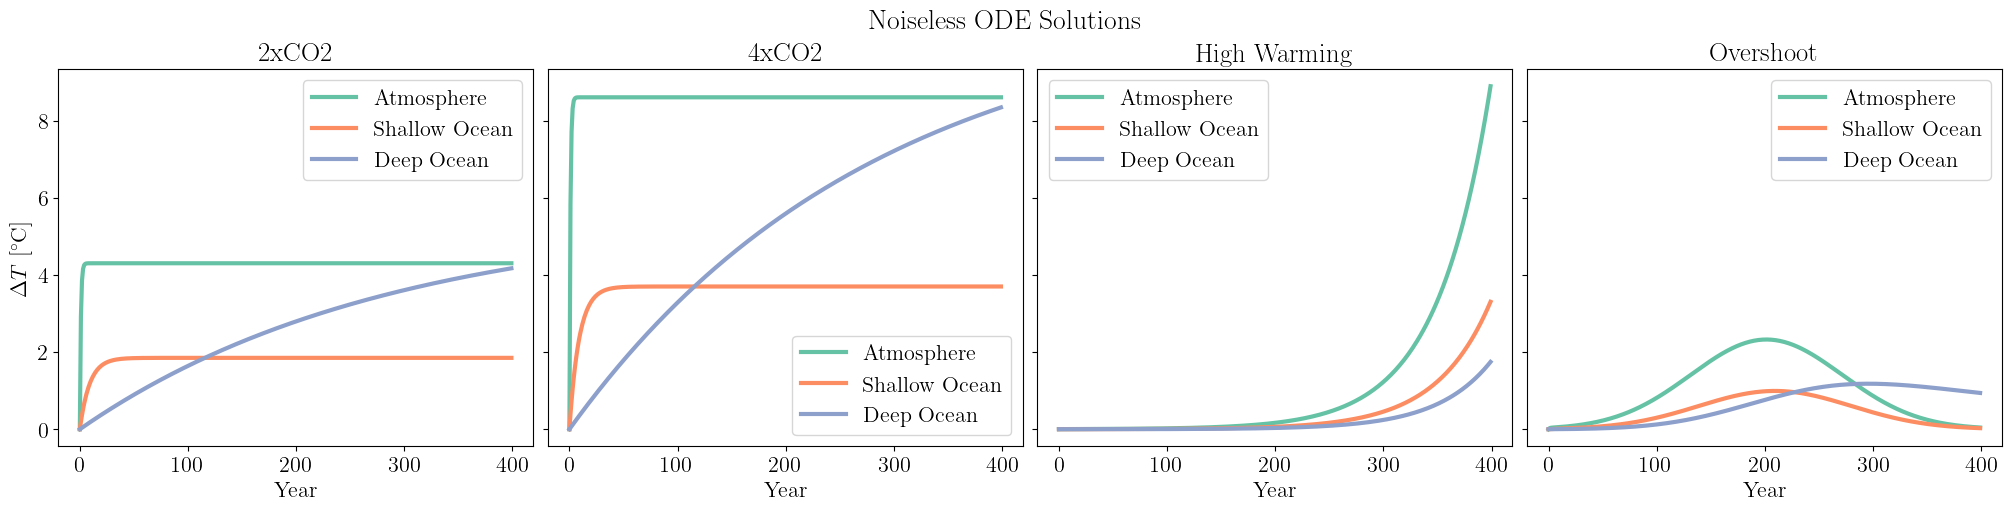

In [6]:
T_ODE, g_ODE, a_ODE = utils_uncoup.create_uncoup(noisy=False)

#### Method 1: Direct derivation of Green's function

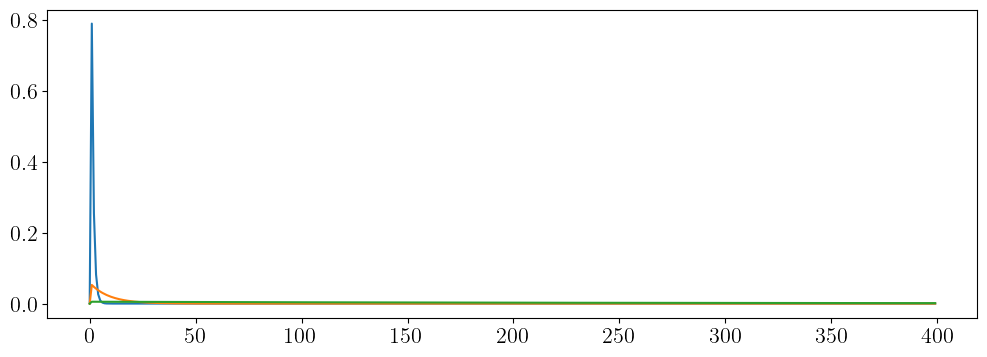

In [10]:
exp = '2xCO2'
for loc in utils_uncoup.regions:
  plt.plot(G[exp][loc])

Error from Raw estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, High Warming: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0

Error from Modal estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, High Warming: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



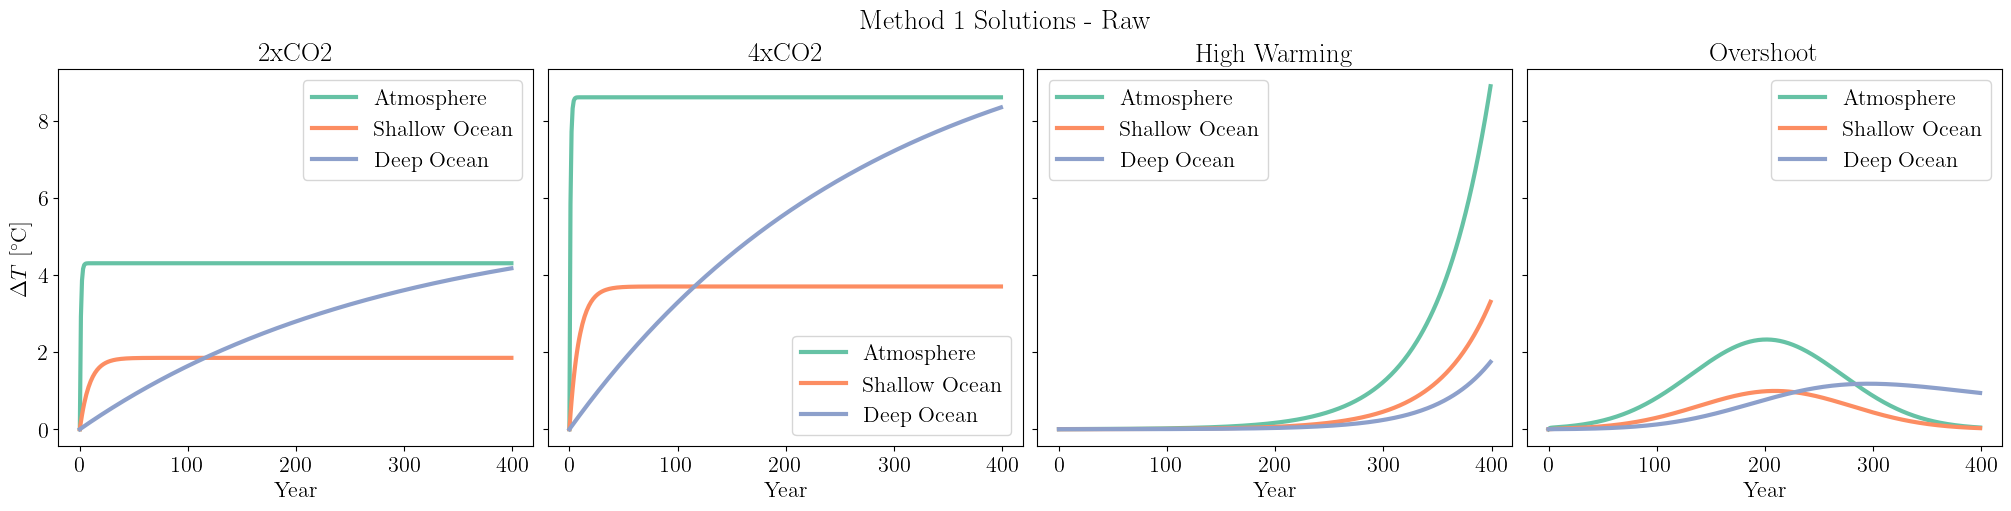

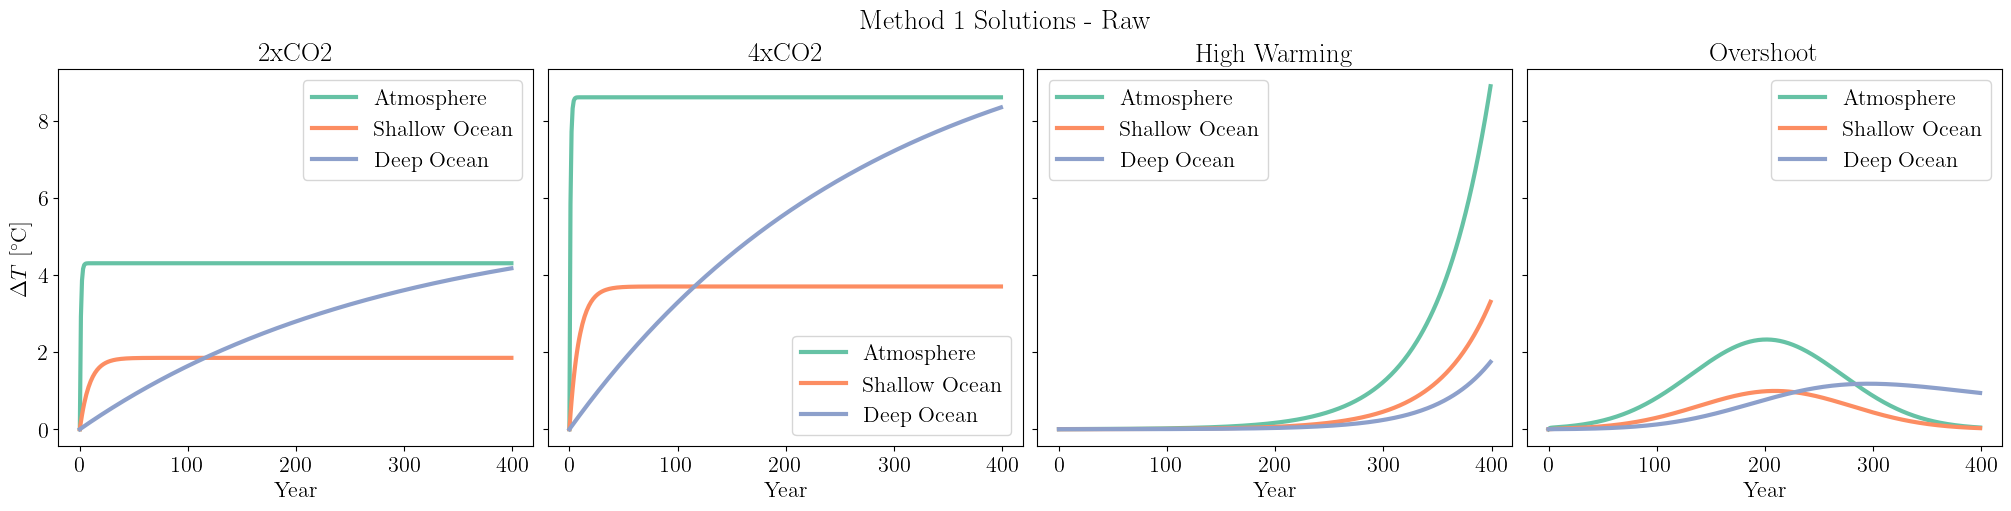

In [8]:
T_raw_method_1, T_modal_method_1, L2_raw_method_1, L2_modal_method_1, G = utils_uncoup.method_1_direct(T_ODE, modal=True)

#### Method 2: DMD and EDMD

In [104]:
experiments = np.copy(utils_uncoup.experiments)
outputs = T_ODE
n_steps = len(utils_uncoup.t)
w0 = np.array([0.0,0.0,0.0])
dt = 1
forcings = {}
for exp in experiments:
  forcings[exp] = np.tile(utils_uncoup.F_all[exp], (3, 1))

operator = emulator_utils.emulate_experiments(experiments, outputs, forcings, 'DMD', w0, dt, n_steps)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 1.2211174966131755e-12
	Test: 4xCO2 - 2.442234993226351e-12
	Test: High Warming - 5.122707064162838e-13
	Test: Overshoot - 4.986348556279079e-13
Train: 4xCO2 - L2 Error
	Test: 2xCO2 - 1.2211174966131755e-12
	Test: 4xCO2 - 2.442234993226351e-12
	Test: High Warming - 5.122707064162838e-13
	Test: Overshoot - 4.986348556279079e-13
Train: High Warming - L2 Error
	Test: 2xCO2 - 2.6449189409391137e-10
	Test: 4xCO2 - 5.289837881878227e-10
	Test: High Warming - 4.2292654121353054e-12
	Test: Overshoot - 5.911258792032378e-11
Train: Overshoot - L2 Error
	Test: 2xCO2 - 4.908321140747787e-10
	Test: 4xCO2 - 9.816642281495574e-10
	Test: High Warming - 7.376397196197423e-11
	Test: Overshoot - 1.3721394970781693e-10


In [116]:
experiments = np.copy(utils_uncoup.experiments)
outputs = T_ODE
n_steps = len(utils_uncoup.t)
w0 = np.array([0.0,0.0,0.0])
dt = 1
forcings = {}
for exp in experiments:
  forcings[exp] = np.tile(utils_uncoup.F_all[exp], (3, 1))

w_dict = emulator_utils.Vector_Dict(method='polynomial', degree=2)
F_dict = emulator_utils.Vector_Dict(method='polynomial', degree=2)

operator = emulator_utils.emulate_experiments(experiments, outputs, forcings, 'EDMD', w0, dt, n_steps, w_dict, F_dict)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 5.637670238651089e-12
	Test: 4xCO2 - 202.58086294603663
	Test: High Warming - 27.475593931212856
	Test: Overshoot - 17.17760352523617
Train: 4xCO2 - L2 Error
	Test: 2xCO2 - 53.48858292294334
	Test: 4xCO2 - 1.4106677323841979e-11
	Test: High Warming - 19.4733495415802
	Test: Overshoot - 24.862351197869863
Train: High Warming - L2 Error
	Test: 2xCO2 - 3.886558468010714e-06
	Test: 4xCO2 - 1.55470163417406e-05
	Test: High Warming - 3.5374632853871636e-07
	Test: Overshoot - 5.156551146919868e-07
Train: Overshoot - L2 Error
	Test: 2xCO2 - 4.281620027886083e-09
	Test: 4xCO2 - 1.7563356931792094e-08
	Test: High Warming - 5.00921968981356e-10
	Test: Overshoot - 4.453759785322929e-10


#### Method 3: Direct deconvolution of response function from dataset

Error from Raw estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, High Warming: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0

Error from Modal estimation.
	L2 Error, 2xCO2: 0.0
	L2 Error, 4xCO2: 0.0
	L2 Error, High Warming: 0.0
	L2 Error, Overshoot: 0.0
Avg. L2 Error: 0.0



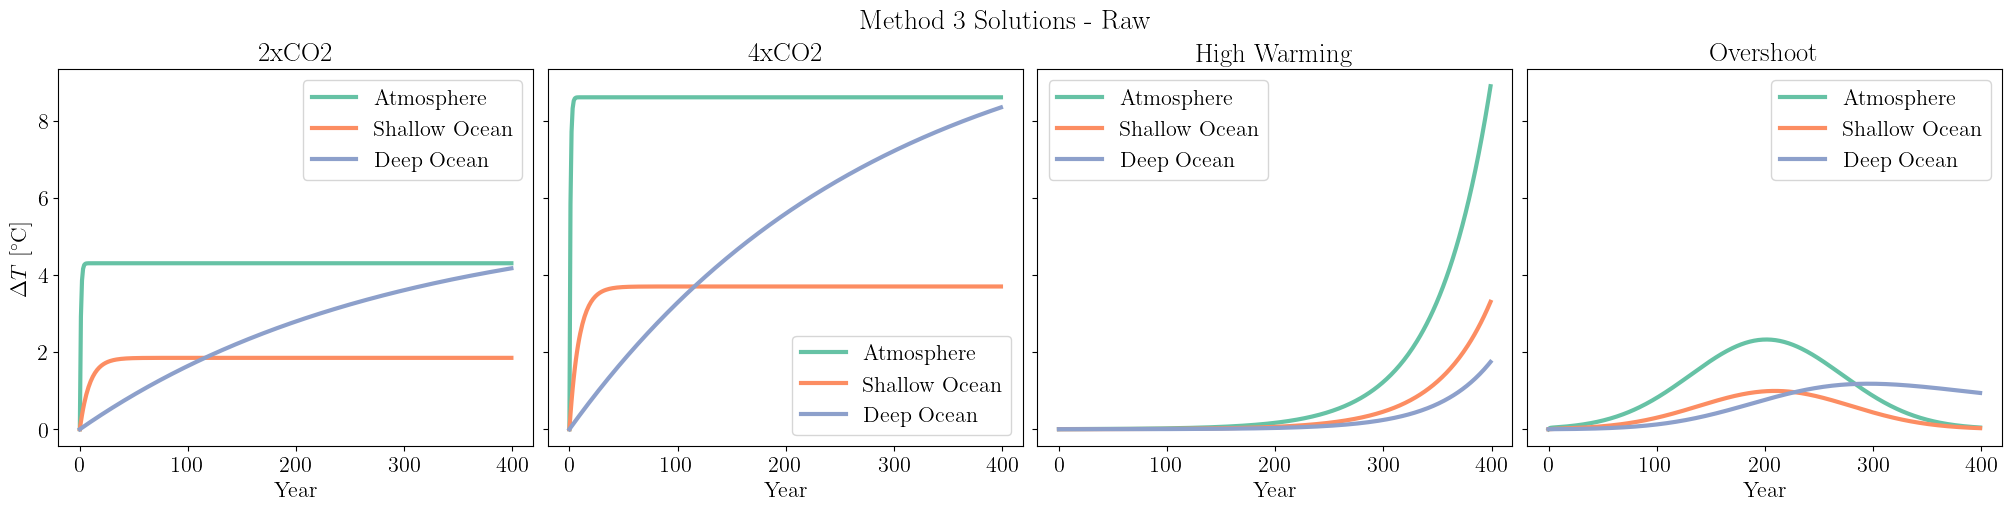

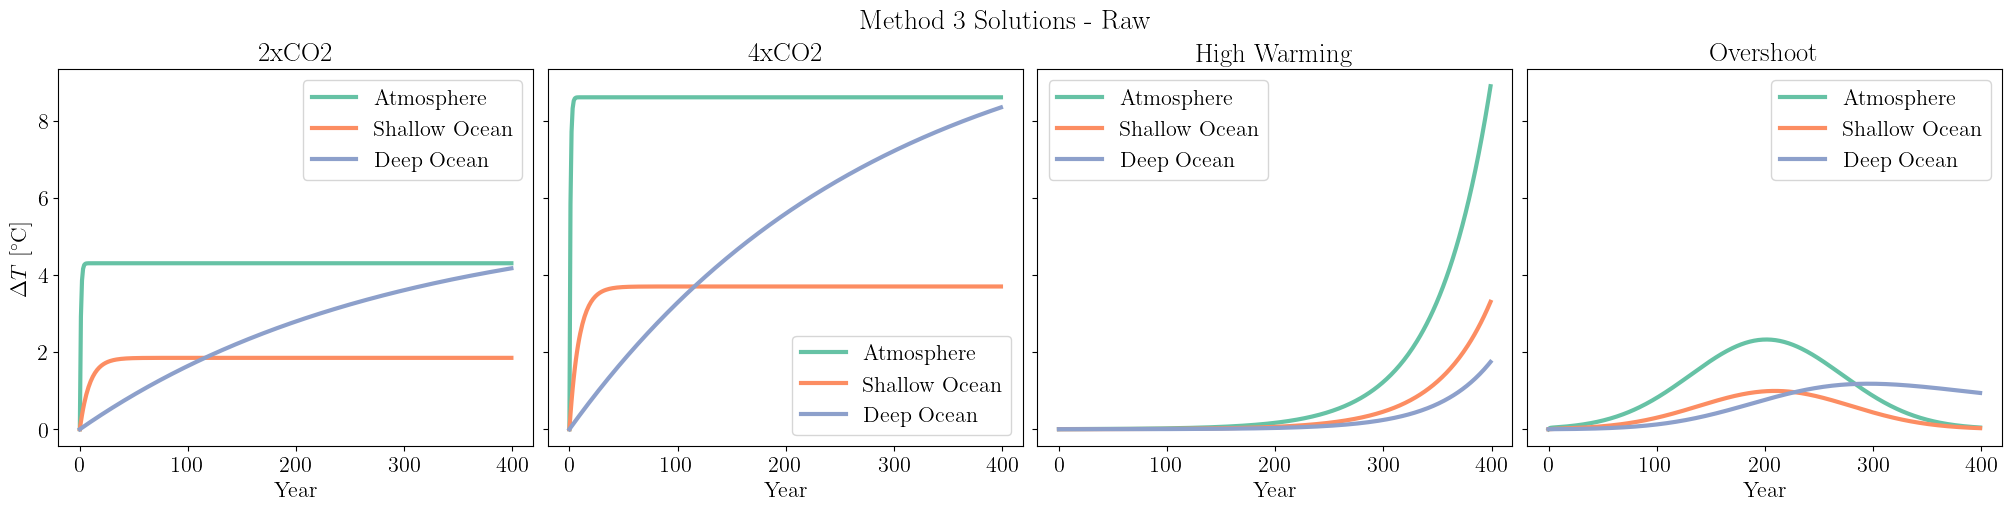

In [11]:
T_raw_method_3, T_modal_method_3, L2_raw_method_3, L2_modal_method_3 = utils_uncoup.method_3_deconv(T_ODE, modal=True)

In [28]:
from scipy.fft import fft, ifft
exp = 'High Warming'
T = T_ODE[exp]['Atmosphere']
F = utils_uncoup.F_exp

In [38]:
import numpy as np

def deconvolve_signal(T, F, epsilon=1e-6):
    """
    Deconvolves two signals in the frequency domain with regularization.

    Parameters:
    - T: array_like, the observed signal (time domain).
    - F: array_like, the filter or impulse response function (time domain).
    - epsilon: float, small regularization constant to avoid division by near-zero values.

    Returns:
    - deconv_T: array_like, the deconvolved signal in the time domain.
    """
    # Compute Fourier Transforms
    T_fft = np.fft.fft(T)
    F_fft = np.fft.fft(F)
    
    # Regularized division in frequency domain
    F_fft_mag_sq = np.abs(F_fft) ** 2  # Avoid complex division artifacts
    G_fft = T_fft * np.conj(F_fft) / (F_fft_mag_sq + epsilon)  # Wiener-like filtering

    # Inverse FFT to get the deconvolved signal in time domain
    deconv_T = np.fft.ifft(G_fft).real  # Take only real part (if data is real)

    return deconv_T

G = deconvolve_signal(T,F,epsilon=1e-1)

In [42]:
import numpy as np

def estimate_response_function(F, T, epsilon=1e-6):
    # Compute Fourier Transforms
    T_fft = np.fft.fft(T)
    F_fft = np.fft.fft(F)
    
    # Regularized division to estimate response function in frequency domain
    G_fft = T_fft / (F_fft + epsilon)
    
    # Inverse FFT to get estimated response function in time domain
    G_est = np.fft.ifft(G_fft).real  # Take only real part if input is real

    return G_est


G = estimate_response_function(T,F,epsilon=1e-6)

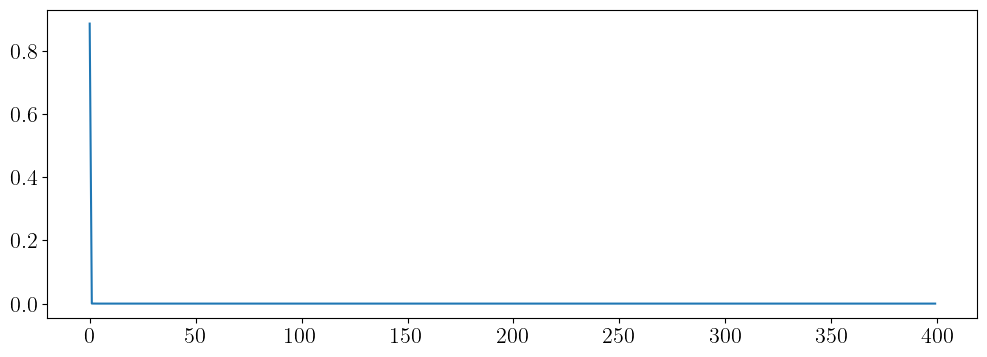

In [43]:
plt.plot(G_)

#### Method 4: Estimation of response function using only leading timescales

Error from Raw estimation.
	L2 Error, 2xCO2: 0.00056
	L2 Error, 4xCO2: 0.0005
	L2 Error, High Warming: 0.00298
	L2 Error, Overshoot: 2e-05
Avg. L2 Error: 0.00101

Error from Modal estimation.
	L2 Error, 2xCO2: 0.00014
	L2 Error, 4xCO2: 0.00016
	L2 Error, High Warming: 0.00294
	L2 Error, Overshoot: 1e-05
Avg. L2 Error: 0.00081



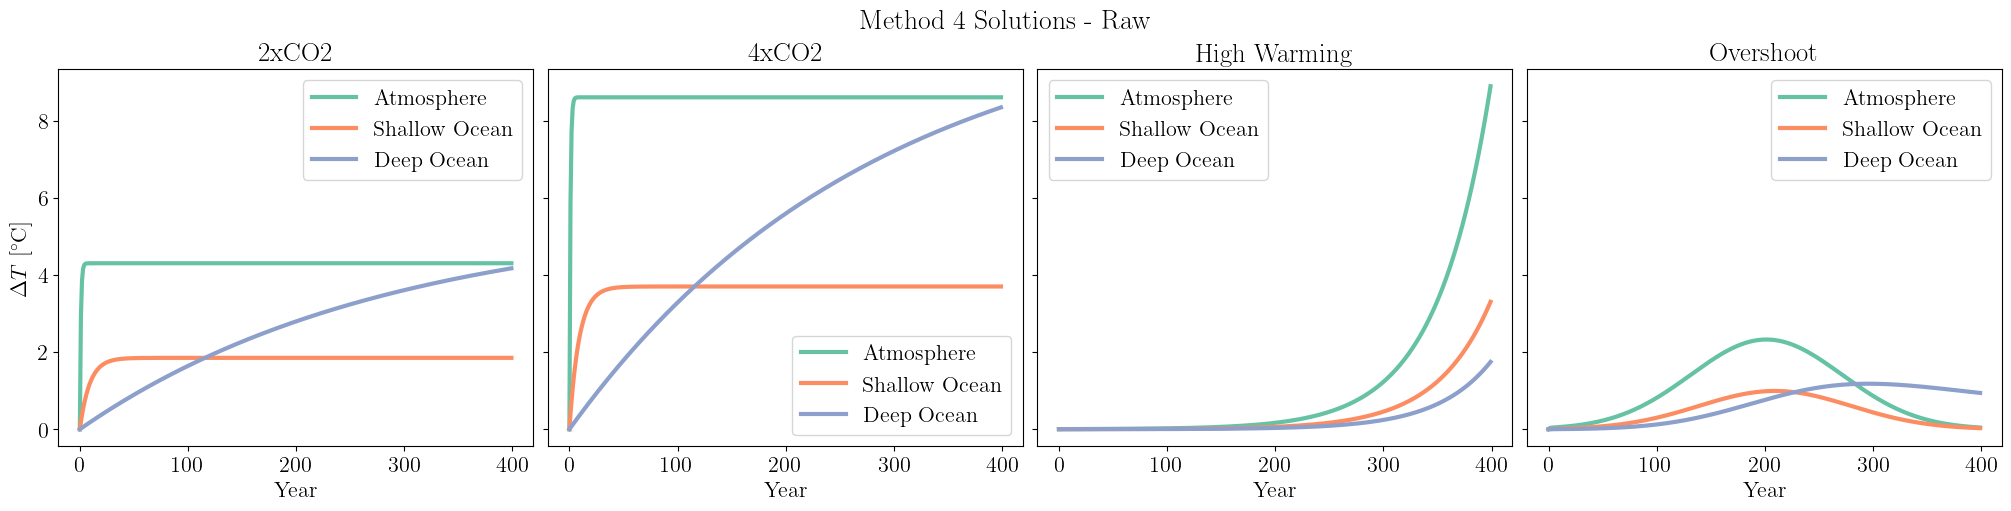

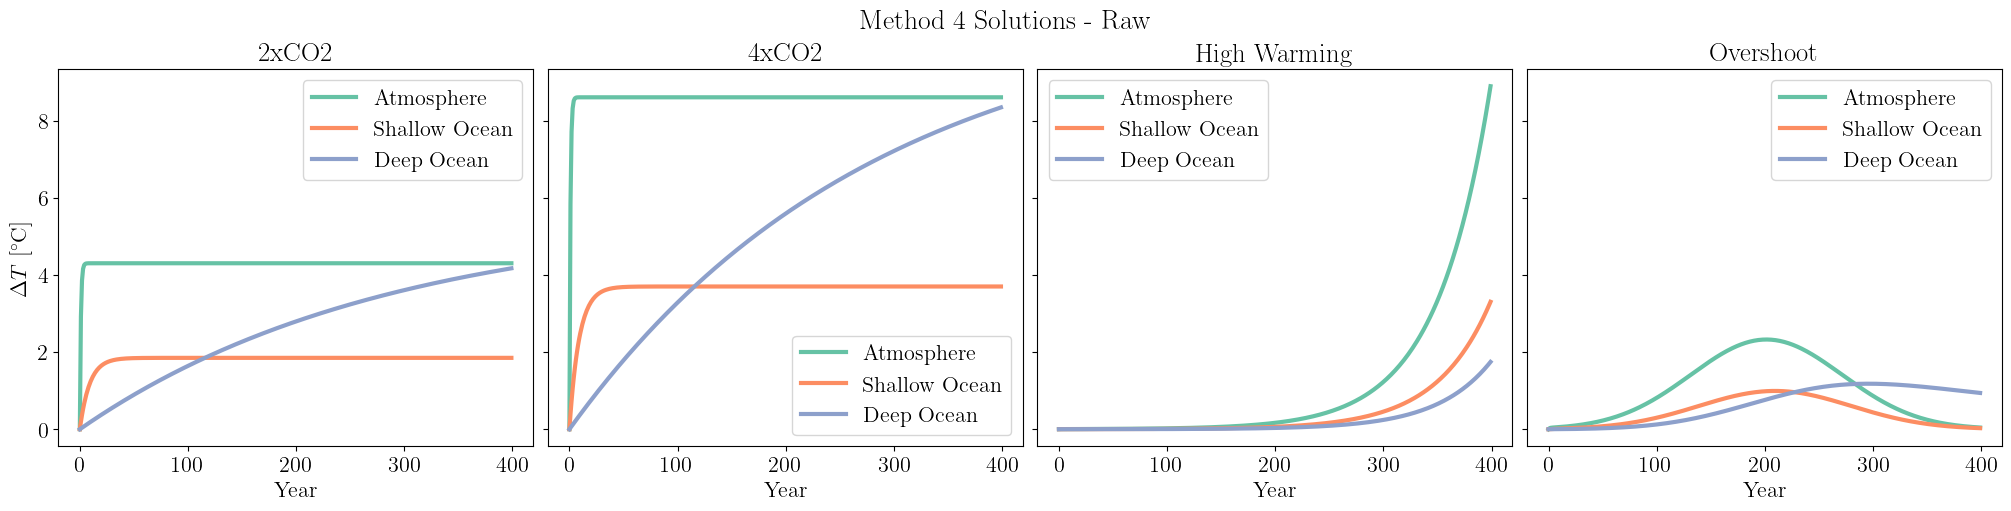

In [12]:
T_raw_method_4, T_modal_method_4, L2_raw_method_4, L2_modal_method_4, res_raw = utils_uncoup.method_4_fit(T_ODE, g_ODE, a_ODE, modal=True)